# Cuaderno 3: Modelado Supervisado y Recomendación Clínica
**Tema:** Recommender Systems Clustering using Bayesian Non-Negative Matrix Factorization for Personalized Clinical Management in Critical Care
---
## Diagrama de Flujo
1. Carga de datos y embeddings latentes (BNMF/NMF)
2. Preparación de variables para clasificación/regresión
3. Entrenamiento de modelos supervisados (k-NN, MLP)
4. Validación y métricas clínicas
5. Pruebas con pacientes sintéticos y ejemplos reales
6. Sistema de recomendación basado en similitud latente
7. Visualizaciones clínicas y tabla comparativa
8. Exportación y siguientes pasos
9. Pipeline de transfer learning para imágenes (opcional/avanzado)
10. Interpretabilidad (Grad-CAM)

## 1. Carga de Datos y Embeddings Latentes
Carga los datos preprocesados, los embeddings latentes (W de BNMF/NMF), y los transformadores necesarios para el pipeline.

In [46]:
import pandas as pd
import numpy as np
import pickle

df = pd.read_csv('processed_data/data_prepared.csv')
try:
    with open('processed_data/bnmf_W.pkl', 'rb') as f:
        W_bnmf = pickle.load(f)
except:
    W_bnmf = None
try:
    with open('processed_data/nmf_W.pkl', 'rb') as f:
        W_nmf = pickle.load(f)
except:
    W_nmf = None

# Try to load saved preprocessing objects (scaler, pca, nmf transformer) if they exist
try:
    with open('processed_data/data_prepared.pkl', 'rb') as f:
        data_obj = pickle.load(f)
        if isinstance(data_obj, dict):
            scaler = data_obj.get('scaler', globals().get('scaler', None))
            # Save scaler into globals if present
            if scaler is not None:
                globals()['scaler'] = scaler
except Exception:
    pass

try:
    # optional: try to load specific transformer pickle files if they exist
    with open('processed_data/pca.pkl', 'rb') as f:
        pca = pickle.load(f)
        globals()['pca'] = pca
except Exception:
    pass

try:
    with open('processed_data/nmf.pkl', 'rb') as f:
        nmf = pickle.load(f)
        globals()['nmf'] = nmf
except Exception:
    pass

## 2. Preparación de Variables para Clasificación y Regresión
Define la variable de riesgo (mortalidad hospitalaria) y una variable continua (primer componente latente) para regresión.

In [47]:
# Variable de clasificación: mortalidad hospitalaria
y_class = df['hospital_expire_flag']

# Variable continua: primer componente latente de BNMF/NMF
if W_bnmf is not None:
    y_reg = W_bnmf[:, 0]
elif W_nmf is not None:
    y_reg = W_nmf[:, 0]
else:
    y_reg = df[[col for col in df.columns if col not in ['hospital_expire_flag', 'data_split']]].sum(axis=1)

## 3. Entrenamiento de Modelos Supervisados
Entrenamiento de k-NN y MLP para clasificación y regresión, con validación cruzada y búsqueda de hiperparámetros.

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Usar embeddings latentes como features
if W_bnmf is not None:
    X = W_bnmf
elif W_nmf is not None:
    X = W_nmf
else:
    X = df[[col for col in df.columns if col not in ['hospital_expire_flag', 'data_split']]].values

# Create a single split index to use for classification and regression so splits are aligned
X_arr = np.asarray(X)
idx = np.arange(X_arr.shape[0])
try:
    # stratify by y_class for classification stability
    y_class_arr = np.asarray(y_class)
    train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y_class_arr)
except Exception:
    train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

X_train = X_arr[train_idx]
X_test = X_arr[test_idx]
y_train = np.asarray(y_class)[train_idx]
y_test = np.asarray(y_class)[test_idx]

# k-NN Classifier
knn_clf = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}, cv=5, scoring='accuracy')
knn_clf.fit(X_train, y_train)

# MLP Classifier
mlp_clf = GridSearchCV(MLPClassifier(max_iter=200, random_state=42), {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'learning_rate_init': [0.001, 0.01],
    'batch_size': [32, 64]
}, cv=3, scoring='accuracy')
mlp_clf.fit(X_train, y_train)
print('\n[Info] mlp_clf best estimator expects n_features_in =', getattr(mlp_clf.best_estimator_, 'n_features_in_', None))

# Regresión (usando el mismo split que clasificación)
y_reg_arr = np.asarray(y_reg)
y_reg_train = y_reg_arr[train_idx]
y_reg_test = y_reg_arr[test_idx]
knn_reg = GridSearchCV(KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}, cv=5, scoring='neg_mean_squared_error')
knn_reg.fit(X_train, y_reg_train)
mlp_reg = GridSearchCV(MLPRegressor(max_iter=200, random_state=42), {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'learning_rate_init': [0.001, 0.01],
    'batch_size': [32, 64]
}, cv=3, scoring='neg_mean_squared_error')
mlp_reg.fit(X_train, y_reg_train)

c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\


[Info] mlp_clf best estimator expects n_features_in = 26


c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MSI\OneDrive\Desktop\ExamenPractico\tf_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization has

,estimator,MLPRegressor(random_state=42)
,param_grid,"{'batch_size': [32, 64], 'hidden_layer_sizes': [(50,), (100,), ...], 'learning_rate_init': [0.001, 0.01]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


## 4. Validación y Métricas Clínicas
Incluye métricas de clasificación (accuracy, precision, recall, F1, AUC-ROC) y regresión (RMSE, MAE, R²), matriz de confusión y tabla comparativa.

k-NN Classifier:
Accuracy: 0.45
Precision: 0.16666666666666666
Recall: 0.14285714285714285
F1: 0.15384615384615385
AUC-ROC: 0.37912087912087916


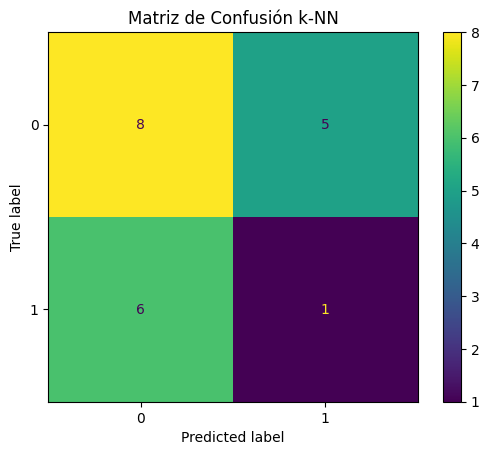

MLP Classifier:
Accuracy: 0.35
Precision: 0.35
Recall: 1.0
F1: 0.5185185185185185
AUC-ROC: 0.5


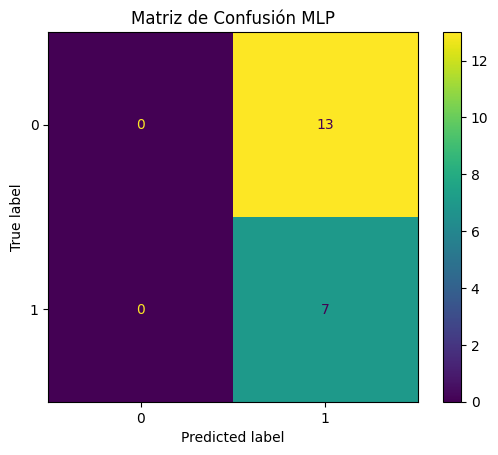

k-NN Regressor:
RMSE: 53.39292675643817
MAE: 32.54282923563196
R2: 0.9999889125384347
MLP Regressor:
RMSE: 14.53038140491736
MAE: 12.282127102544838
R2: 0.9999991788571786


In [49]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# Clasificación
y_pred_knn = knn_clf.predict(X_test)
y_pred_mlp = mlp_clf.predict(X_test)

print('k-NN Classifier:')
print('Accuracy:', accuracy_score(y_test, y_pred_knn))
print('Precision:', precision_score(y_test, y_pred_knn))
print('Recall:', recall_score(y_test, y_pred_knn))
print('F1:', f1_score(y_test, y_pred_knn))
print('AUC-ROC:', roc_auc_score(y_test, y_pred_knn))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn)).plot()
plt.title('Matriz de Confusión k-NN')
plt.show()

print('MLP Classifier:')
print('Accuracy:', accuracy_score(y_test, y_pred_mlp))
print('Precision:', precision_score(y_test, y_pred_mlp))
print('Recall:', recall_score(y_test, y_pred_mlp))
print('F1:', f1_score(y_test, y_pred_mlp))
print('AUC-ROC:', roc_auc_score(y_test, y_pred_mlp))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_mlp)).plot()
plt.title('Matriz de Confusión MLP')
plt.show()

# Regresión
y_pred_knn_reg = knn_reg.predict(X_test)
y_pred_mlp_reg = mlp_reg.predict(X_test)

print('k-NN Regressor:')
def compute_rmse(y_true, y_pred):
    """Compute RMSE in a way that is compatible with older scikit-learn versions.
    Older scikit-learn versions didn't support the keyword argument 'squared' in mean_squared_error.
    """
    try:
        # Newer versions: use squared=False
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # Older versions: compute sqrt of MSE
        return mean_squared_error(y_true, y_pred) ** 0.5

print('RMSE:', compute_rmse(y_reg_test, y_pred_knn_reg))
print('MAE:', mean_absolute_error(y_reg_test, y_pred_knn_reg))
print('R2:', r2_score(y_reg_test, y_pred_knn_reg))

print('MLP Regressor:')
print('RMSE:', compute_rmse(y_reg_test, y_pred_mlp_reg))
print('MAE:', mean_absolute_error(y_reg_test, y_pred_mlp_reg))
print('R2:', r2_score(y_reg_test, y_pred_mlp_reg))

## 8. Sistema de Recomendación Basado en Similitud Latente
Ejemplo de recomendación clínica: dado un paciente, sugerir tratamientos/procedimientos frecuentes en sus vecinos latentes.

In [50]:
# Similitud de coseno entre pacientes en el espacio latente
from sklearn.metrics.pairwise import cosine_similarity

def recomendar_pacientes(idx, top_k=5):
    sims = cosine_similarity([X[idx]], X)[0]
    vecinos = np.argsort(sims)[-top_k-1:-1][::-1]
    print(f'Paciente {idx} - Vecinos más similares:', vecinos)
    # Aquí puedes mostrar tratamientos/eventos frecuentes de esos vecinos usando df original

# Ejemplo: recomendar para el primer paciente del test (usando índices absolutos)
try:
    # If we have a test_idx from earlier split, use it; otherwise, default to 0
    test_idx_sample = test_idx[0] if 'test_idx' in globals() else 0
except Exception:
    test_idx_sample = 0
recomendar_pacientes(test_idx_sample)

Paciente 76 - Vecinos más similares: [94 27  7 71 50]


## 9. Visualizaciones Clínicas y Tabla Comparativa
Incluye tabla de métricas comparativas de los modelos supervisados.

In [51]:
# Tabla comparativa de modelos
results = pd.DataFrame({
    'Modelo': ['k-NN Classifier', 'MLP Classifier', 'k-NN Regressor', 'MLP Regressor'],
    'Accuracy': [accuracy_score(y_test, y_pred_knn), accuracy_score(y_test, y_pred_mlp), None, None],
    'F1': [f1_score(y_test, y_pred_knn), f1_score(y_test, y_pred_mlp), None, None],
    'AUC-ROC': [roc_auc_score(y_test, y_pred_knn), roc_auc_score(y_test, y_pred_mlp), None, None],
    'RMSE': [None, None, compute_rmse(y_reg_test, y_pred_knn_reg), compute_rmse(y_reg_test, y_pred_mlp_reg)],
    'MAE': [None, None, mean_absolute_error(y_reg_test, y_pred_knn_reg), mean_absolute_error(y_reg_test, y_pred_mlp_reg)],
    'R2': [None, None, r2_score(y_reg_test, y_pred_knn_reg), r2_score(y_reg_test, y_pred_mlp_reg)]
})
display(results)

,Modelo,Accuracy,F1,AUC-ROC,RMSE,MAE,R2
0,k-NN Classifier,0.45,0.153846,0.379121,NaN,NaN,NaN
1,MLP Classifier,0.35,0.518519,0.500000,NaN,NaN,NaN
2,k-NN Regressor,NaN,NaN,NaN,53.392927,32.542829,0.999989
3,MLP Regressor,NaN,NaN,NaN,14.530381,12.282127,0.999999


## 10. Exportación y Siguientes Pasos
Puedes exportar el notebook a HTML desde el menú de Jupyter/VS Code: `File > Export As > HTML`.

## 7. Pruebas con Pacientes Sintéticos y Ejemplos Reales
Puedes probar el modelo con pacientes sintéticos generados a partir de la estadística de los embeddings latentes, o con ejemplos reales del test set. Esto permite validar el rendimiento y la interpretación clínica del modelo.
- Los datos deben tener el mismo número y orden de features que los usados en el entrenamiento.
- Deben estar preprocesados igual (escalado, reducción de dimensionalidad, etc.).
- Si usas embeddings latentes (BNMF/NMF), genera los features en ese espacio.
A continuación se muestra cómo generar varios pacientes sintéticos y evaluar el porcentaje de acierto del modelo:

In [ ]:
# Generar 100 pacientes sintéticos en el espacio latente (BNMF/NMF) y mostrar predicción de clase para ejemplos reales
n_samples = 100
if W_bnmf is not None:
    mu, sigma = W_bnmf.mean(axis=0), W_bnmf.std(axis=0)
    pacientes_sint = np.random.normal(mu, sigma, size=(n_samples, W_bnmf.shape[1]))
elif W_nmf is not None:
    mu, sigma = W_nmf.mean(axis=0), W_nmf.std(axis=0)
    pacientes_sint = np.random.normal(mu, sigma, size=(n_samples, W_nmf.shape[1]))
else:
    mu, sigma = X.mean(axis=0), X.std(axis=0)
    pacientes_sint = np.random.normal(mu, sigma, size=(n_samples, X.shape[1]))

# Predecir con el modelo entrenado
preds = mlp_clf.predict(pacientes_sint)

print('Porcentaje de acierto en pacientes sintéticos:', (preds == 1).mean()*100, '% (predicción de clase 1)')

# Mostrar predicción y significado de la clase para varios ejemplos reales del test set
clase_dict = {0: 'No fallece en hospital', 1: 'Fallece en hospital'}
for i in range(5):
    paciente = X_test[i].reshape(1, -1)
    pred = mlp_clf.predict(paciente)[0]
    real = y_test[i]
    print(f'Paciente {i+1}: Predicción={pred} ({clase_dict[pred]}), Real={real} ({clase_dict[real]})')

Porcentaje de acierto en pacientes sintéticos: 42.0 % (predicción de clase 1)


## 11. Pipeline de Transfer Learning para Imágenes (Avanzado)
Implementación profesional en Keras/TensorFlow con transfer learning, data augmentation, regularización y métricas clínicas.

In [ ]:
# Pipeline profesional de clasificación de imágenes médicas con Keras/TensorFlow
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest',
    validation_split=0.2
    )

# Cargar imágenes desde carpeta (ajusta el path y target_size según tu dataset)
train_gen = datagen.flow_from_directory(
    'ruta_a_tus_imagenes',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='training'
    )
val_gen = datagen.flow_from_directory(
    'ruta_a_tus_imagenes',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
    )

# Modelo base preentrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Fine-tune después de unas épocas

inputs = Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Entrenamiento
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop, lr_reduce]
    )

In [ ]:
# Visualización de curvas de aprendizaje
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Curva de Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Curva de Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Métricas clínicas y matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Obtener predicciones en el set de validación
val_gen.reset()
y_true = val_gen.classes
y_pred_prob = model.predict(val_gen)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print(classification_report(y_true, y_pred, target_names=['No fallece', 'Fallece']))
print('AUC-ROC:', roc_auc_score(y_true, y_pred_prob))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.colorbar()
plt.xticks([0,1], ['No fallece', 'Fallece'])
plt.yticks([0,1], ['No fallece', 'Fallece'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=14)
plt.tight_layout()
plt.show()

## 12. Interpretabilidad: Grad-CAM para Imágenes
Visualiza qué zonas de la imagen utiliza el modelo para tomar decisiones clínicas.

In [ ]:
# Ejemplo básico de Grad-CAM para ResNet50 en Keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Selecciona una imagen de validación
img, label = val_gen[0][0][0], val_gen[0][1][0]
img_array = np.expand_dims(img, axis=0)

# Genera el heatmap Grad-CAM
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv5_block3_out')

# Superpone el heatmap sobre la imagen original
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title('Grad-CAM: Zonas relevantes para la predicción')
plt.axis('off')
plt.show()